In [83]:
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os
from scipy.signal import freqz

# Funções auxiliares

In [84]:
# Função para criar o filtro FIR com os pesos fornecidos
def fir_filter(x, weights):
    order = len(weights) - 1
    y = np.zeros_like(x)
    for n in range(len(x)):
        for k in range(len(weights)):
            if n - k >= 0:
                y[n] += (weights[k] * x[n - k])
                #y[n] = np.trunc(y[n])
    return y

In [85]:
def signal_power(x):
    return np.sum(np.mean(x * np.conj(x), axis=0).real)

In [86]:
def calcular_mse(somador_completo, comparador):
    return np.mean((somador_completo - comparador) ** 2)

In [87]:
def ler_valores_saida(nome_arquivo):
    with open(nome_arquivo, 'r') as arquivo:
        valores = arquivo.read().strip().split(',')
        valores = [float(valor) for valor in valores if valor]  # Remove valores vazios
        return np.array(valores[12:])
        #return np.array(valores)
    

In [88]:
def nlms(u, d, taps, mu):
    """ Normalized Least Mean Squares (NLMS)
    
    Simples implementação do algoritmo NLMS para filtragem adaptativa.

    Args:
        u (np.array): sinal de entrada unidimensional 
        d (np.array): sinal de referência unidimensional
        taps (int)  : número de coeficientes do filtro   
        mu (float)  : tamanho do passo para o NLMS

    Returns:
        tuple: 
            - np.array: sinal de saída.
            - np.array: sinal de erro.
            - np.array: erro quadrático.
            - np.array: coeficintes do filtro após a convergência.

    Referências:
        [1] Adaptive Filtering: Algorithms and Practical Implementation
    """
    
    # número de iterações para filtragem adaptativa
    N = len(u) - taps + 1
    
    # deriva um filtro real ou complexo
    dtype = u.dtype
    
    # obtém o atraso da filtragem FIR
    delay = (taps-1) // 2

    y = np.zeros(len(u), dtype=dtype)     # saída do filtro
    e = np.zeros(len(u), dtype=dtype)     # sinal de erro
    w = np.zeros(taps, dtype=dtype)       # coeficientes iniciais do filtro.

    err_square = np.zeros(len(u), dtype=dtype)   # erro quadrático
    
    # Execulta a filtragem adaptativa
    for n in range(N):
        # Garante que n + delay não exceda len(d) - 1
        if n + delay >= len(d):
            break
        
        # janela deslizante correspondente a ordem do filtro
        x = np.flipud(u[n:n+taps])

        # calcula a saída no instante n
        y[n] = np.dot(x, w)
        
        # calcula o erro
        e[n] = d[n + delay] - y[n]

        # calcula os novos coeficientes do filtro usando a normalização
        norm_factor = np.dot(x, np.conj(x)) + 1e-6  # adicione um pequeno valor para evitar divisão por zero
        w += mu * np.conj(x) * e[n] / norm_factor

        # calcula o erro quadrático
        err_square[n] = e[n]**2

    return y, e, err_square, w

# Calculando valores dos pesos e aplicando o filtro

In [89]:
record_path = 'C:/Users/ewert/Downloads/mit-bih-normal-sinus-rhythm-database-1.0.0/16265'

# Carregar uma gravação do banco de dados
record = wfdb.rdrecord(record_path)
signal = record.p_signal[:, 0]  # Seleciona o primeiro canal
fs = record.fs  # Frequência de amostragem do sinal

# Parâmetros do ruído de interferência da linha de energia
f_noise = 60  # Frequência do ruído (60 Hz)
t = np.arange(len(signal))  # Vetor de tempo (em amostras)

# Gerar o ruído senoidal
noise = 0.05 * np.sin(2 * np.pi * f_noise * t / fs)

# Adicionar o ruído ao sinal original
signal_noisy = signal + noise

In [90]:
y, e, err_square, w = nlms(signal_noisy, signal, 9, 0.001)
w1 = w

b2 = np.zeros(len(w))
for i in range(len(w)):
    b2[i] = 2*np.trunc(w[i] * (2**6))

signal2 = np.zeros(len(signal))
for i in range(len(signal)):
    signal2[i] = np.trunc(signal[i]*(2**6))
    
np.savetxt('signal_bd.txt', signal2, fmt='%d')
    
# Assumindo que fir_filter é uma função definida anteriormente
y2 = fir_filter(signal2, b2)
y2 = y2 / (2**12)

# Análisando a Reposta em Frequência do Filtro

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


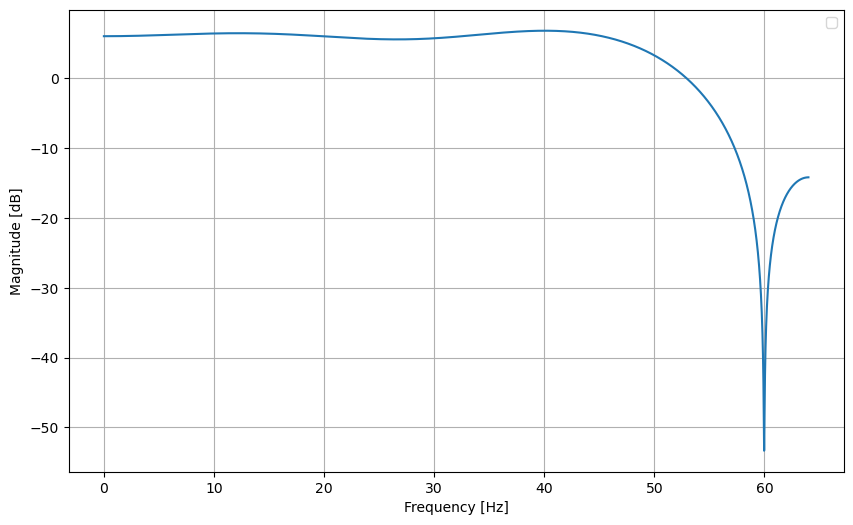

In [91]:
# Frequência de amostragem (em Hz)
fs = 128  # Frequência de amostragem

# Calcular a resposta em frequência
w, h = freqz(2*w1, worN=8000)

# Converter radianos para Hz
frequencies_hz = w * fs / (2 * np.pi)

# Plotar a magnitude da resposta em frequência
plt.figure(figsize=(10, 6))
plt.plot(frequencies_hz, 20 * np.log10(abs(h)))
#plt.title('Resposta em Frequência do Filtro FIR')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.legend()
plt.show()

# Análise do sinal

In [92]:
ruido = signal - y2[:len(signal)]
potencia_sinal = signal_power(y2)
potencia_ruido = signal_power(ruido)
snr = 10 * np.log10(potencia_sinal / potencia_ruido)
print("SNR após o tratamento =", snr, "dB")

SNR após o tratamento = -1.3850743589611123 dB


In [93]:
arquivos_saida = ['Sinal_BD/saida.txt','Sinal_BD/2T2.txt','Sinal_BD/2TN.txt','Sinal_BD/2U6.txt',
                  'Sinal_BD/2UB.txt','Sinal_BD/2UY.txt','Sinal_BD/2X2.txt','Sinal_BD/2YM.txt', 
                  'Sinal_BD/3BD.txt','Sinal_BD/32R.txt','Sinal_BD/32T.txt','Sinal_BD/35M.txt',
                  'Sinal_BD/334.txt','Sinal_BD/349.txt','Sinal_BD/EMB.txt']

snrs = []
for arquivo_saida in arquivos_saida:
    if not os.path.exists(arquivo_saida):
        print(f"Arquivo {arquivo_saida} não encontrado.")
        continue
    
    sinal_out= ler_valores_saida(arquivo_saida)
    sinal_out1 = np.zeros(len(signal))
    sinal_out1 = sinal_out[:len(signal)]/(2**12)

    potencia_ruido = signal_power(ruido)
    potencia_sinal = signal_power(sinal_out1)
    snr = 10 * np.log10(potencia_sinal / potencia_ruido)

    snrs.append((arquivo_saida[-7:-4], snr))  # Usando as últimas 3 letras como referência

print("Para o sinal artificial:")
    
for snr in snrs:
    if snr[0] == "ida":
        print(f"SNR para somador completo: {snr[1]} dB")
    else:
        print(f"SNR para somador {snr[0]}: {snr[1]} dB")

Para o sinal artificial:
SNR para somador completo: -1.3850743589611123 dB
SNR para somador 2T2: -1.3852340269997445 dB
SNR para somador 2TN: -1.3852356101894365 dB
SNR para somador 2U6: -1.3855141001948057 dB
SNR para somador 2UB: -1.3892102920504956 dB
SNR para somador 2UY: -1.3850743589611123 dB
SNR para somador 2X2: -1.3859933952119228 dB
SNR para somador 2YM: -1.3857936581881871 dB
SNR para somador 3BD: -1.3914948199035473 dB
SNR para somador 32R: -1.365153790351554 dB
SNR para somador 32T: -1.3745992095763417 dB
SNR para somador 35M: -1.3857936581881871 dB
SNR para somador 334: -1.3873435714690407 dB
SNR para somador 349: -1.3866395472528432 dB
SNR para somador EMB: -1.340432739879072 dB


In [94]:
# Arquivo do somador completo
arquivo_somador_completo = 'Sinal_BD/saida.txt'
# Demais arquivos
arquivos_saida = [
    'Sinal_BD/2T2.txt', 'Sinal_BD/2TN.txt', 'Sinal_BD/2U6.txt', 'Sinal_BD/2UB.txt', 
    'Sinal_BD/2UY.txt', 'Sinal_BD/2X2.txt', 'Sinal_BD/2YM.txt', 'Sinal_BD/3BD.txt', 
    'Sinal_BD/32R.txt', 'Sinal_BD/32T.txt', 'Sinal_BD/35M.txt', 'Sinal_BD/334.txt', 
    'Sinal_BD/349.txt', 'Sinal_BD/EMB.txt'
]

# Lendo os valores de saída do somador completo
if not os.path.exists(arquivo_somador_completo):
    print(f"Arquivo {arquivo_somador_completo} não encontrado.")
else:
    somador_completo = ler_valores_saida(arquivo_somador_completo)
    somador_completo = somador_completo[:len(somador_completo)] / (2**12)

mses = []
for arquivo_saida in arquivos_saida:
    if not os.path.exists(arquivo_saida):
        print(f"Arquivo {arquivo_saida} não encontrado.")
        continue
    
    comparador = ler_valores_saida(arquivo_saida)
    comparador = comparador[:len(somador_completo)] / (2**12)
    
    mse = calcular_mse(somador_completo, comparador)
    mses.append((arquivo_saida[-7:-4], mse))  # Usando as últimas 3 letras como referência

print("Para o sinal do BD:")
for mse in mses:
    if mse[0] == "ida":
        print(f"MSE para somador completo: {mse[1]}")
    else:
        print(f"MSE para somador {mse[0]}: {mse[1]}")


Para o sinal do BD:
MSE para somador 2T2: 1.028363504413793e-05
MSE para somador 2TN: 5.960464477539063e-08
MSE para somador 2U6: 3.9610898295210524e-07
MSE para somador 2UB: 7.5776462217174e-05
MSE para somador 2UY: 0.0
MSE para somador 2X2: 1.6827242371837426e-06
MSE para somador 2YM: 1.0974183648827344e-05
MSE para somador 3BD: 0.0006757635454696065
MSE para somador 32R: 0.0005810896317205644
MSE para somador 32T: 0.00025263632175338217
MSE para somador 35M: 1.0974183648827344e-05
MSE para somador 334: 2.1369268798770763e-05
MSE para somador 349: 6.490327712450592e-06
MSE para somador EMB: 0.002512519288173472


# Criando novo sinal com ruido

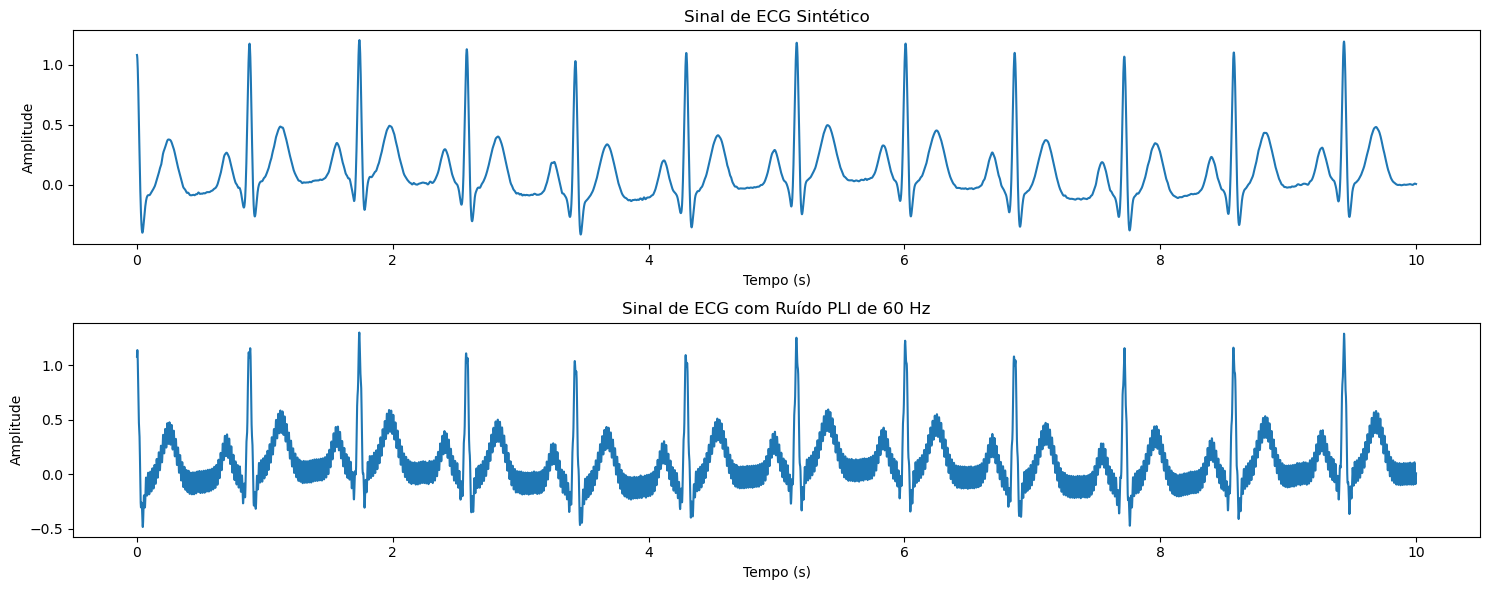

In [95]:
# Gerar um sinal de ECG sintético
sampling_rate = 1000  # Taxa de amostragem em Hz
duration = 10  # Duração em segundos
ecg_signal = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate)

# Gerar ruído de interferência de linha de energia (PLI) de 60 Hz
t = np.linspace(0, duration, int(sampling_rate * duration))
pli_noise = 0.1 * np.sin(2 * np.pi * 60 * t)  # Amplitude do ruído definida como 0.1

# Adicionar o ruído ao sinal de ECG
ecg_with_noise = ecg_signal + pli_noise

# Plotar o sinal de ECG original e o sinal com ruído
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(t, ecg_signal)
plt.title("Sinal de ECG Sintético")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(t, ecg_with_noise)
plt.title("Sinal de ECG com Ruído PLI de 60 Hz")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


# Análisando novo sinal

In [96]:
ruido = ecg_signal - ecg_with_noise
potencia_sinal = signal_power(ecg_with_noise)
potencia_ruido = signal_power(pli_noise)
snr = 10 * np.log10(potencia_sinal / potencia_ruido)
print("SNR do sinal antes da filtragem:",snr,"dB")

SNR do sinal antes da filtragem: 11.556628546470444 dB


In [97]:
y, e, err_square, w = nlms(ecg_with_noise, ecg_signal, 9, 0.001)
w2 = w

b3 = np.zeros(len(w))
for i in range(len(w)):
    b3[i] = 2*np.trunc(w[i] * (2**6))

ecg_aux = np.zeros(len(ecg_with_noise))
for i in range(len(ecg_with_noise)):
    ecg_aux[i] = np.trunc(ecg_with_noise[i]*(2**6))
    
np.savetxt('signal_art.txt', ecg_aux, fmt='%d')


y3 = fir_filter(ecg_aux, b3)
y3 = y3 / (2**12)

#y3 = y3 * 2

In [98]:
potencia_sinal = signal_power(y3)
potencia_ruido = signal_power(pli_noise)
snr = 10 * np.log10(potencia_sinal / potencia_ruido)
print("SNR do sinal após a filtragem via software:",snr,"dB")

SNR do sinal após a filtragem via software: 15.66465768380231 dB


In [99]:
arquivos_saida = ['Sinal_Artificial/saida.txt','Sinal_Artificial/2T2.txt','Sinal_Artificial/2TN.txt','Sinal_Artificial/2U6.txt',
                  'Sinal_Artificial/2UB.txt','Sinal_Artificial/2UY.txt','Sinal_Artificial/2X2.txt','Sinal_Artificial/2YM.txt', 
                  'Sinal_Artificial/3BD.txt','Sinal_Artificial/32R.txt','Sinal_Artificial/32T.txt','Sinal_Artificial/35M.txt',
                  'Sinal_Artificial/334.txt','Sinal_Artificial/349.txt','Sinal_Artificial/EMB.txt']

snrs = []
for arquivo_saida in arquivos_saida:
    if not os.path.exists(arquivo_saida):
        print(f"Arquivo {arquivo_saida} não encontrado.")
        continue
    
    sinal_out= ler_valores_saida(arquivo_saida)
    sinal_out1 = np.zeros(len(ecg_signal))
    sinal_out1 = sinal_out[:len(ecg_signal)]/(2**12)

    potencia_ruido = signal_power(pli_noise)
    potencia_sinal = signal_power(sinal_out1)
    snr = 10 * np.log10(potencia_sinal / potencia_ruido)

    snrs.append((arquivo_saida[-7:-4], snr))  # Usando as últimas 3 letras como referência

print("Para o sinal artificial:")
    
for snr in snrs:
    if snr[0] == "ida":
        print(f"SNR para somador completo: {snr[1]} dB")
    else:
        print(f"SNR para somador {snr[0]}: {snr[1]} dB")

Para o sinal artificial:
SNR para somador completo: 15.637162133413302 dB
SNR para somador 2T2: 15.645130283448907 dB
SNR para somador 2TN: 15.63909692433912 dB
SNR para somador 2U6: 15.64679767888072 dB
SNR para somador 2UB: 15.633580428053795 dB
SNR para somador 2UY: 15.637162133413302 dB
SNR para somador 2X2: 15.647812963569196 dB
SNR para somador 2YM: 15.759521632664729 dB
SNR para somador 3BD: 15.774431848688447 dB
SNR para somador 32R: 15.50598146496197 dB
SNR para somador 32T: 15.61557697256159 dB
SNR para somador 35M: 15.649092669102473 dB
SNR para somador 334: 15.675049087289196 dB
SNR para somador 349: 15.6451949673307 dB
SNR para somador EMB: 15.72145955388181 dB


In [100]:
# Arquivo do somador completo
arquivo_somador_completo = 'Sinal_Artificial/saida.txt'
# Demais arquivos
arquivos_saida = ['Sinal_Artificial/saida.txt','Sinal_Artificial/2T2.txt','Sinal_Artificial/2TN.txt','Sinal_Artificial/2U6.txt',
                  'Sinal_Artificial/2UB.txt','Sinal_Artificial/2UY.txt','Sinal_Artificial/2X2.txt','Sinal_Artificial/2YM.txt', 
                  'Sinal_Artificial/3BD.txt','Sinal_Artificial/32R.txt','Sinal_Artificial/32T.txt','Sinal_Artificial/35M.txt',
                  'Sinal_Artificial/334.txt','Sinal_Artificial/349.txt','Sinal_Artificial/EMB.txt']

# Lendo os valores de saída do somador completo
if not os.path.exists(arquivo_somador_completo):
    print(f"Arquivo {arquivo_somador_completo} não encontrado.")
else:
    somador_completo = ler_valores_saida(arquivo_somador_completo)
    somador_completo = somador_completo[:len(somador_completo)] / (2**12)

mses = []
for arquivo_saida in arquivos_saida:
    if not os.path.exists(arquivo_saida):
        print(f"Arquivo {arquivo_saida} não encontrado.")
        continue
    
    comparador = ler_valores_saida(arquivo_saida)
    comparador = comparador[:len(somador_completo)] / (2**12)
    
    mse = calcular_mse(somador_completo, comparador)
    mses.append((arquivo_saida[-7:-4], mse))  # Usando as últimas 3 letras como referência

print("Para o sinal artificial:")
for mse in mses:
    if mse[0] == "ida":
        print(f"Mse para somador completo: {mse[1]}")
    else:
        print(f"MSE para somador {mse[0]}: {mse[1]}")


Para o sinal artificial:
Mse para somador completo: 0.0
MSE para somador 2T2: 9.362473346219205e-06
MSE para somador 2TN: 5.960464477539063e-08
MSE para somador 2U6: 1.74437419022664e-06
MSE para somador 2UB: 2.1491629062312665e-05
MSE para somador 2UY: 0.0
MSE para somador 2X2: 1.9994348582654897e-06
MSE para somador 2YM: 0.00028678133346066615
MSE para somador 3BD: 0.0005017473201940555
MSE para somador 32R: 0.00025218663829388005
MSE para somador 32T: 8.618358338233267e-05
MSE para somador 35M: 9.572057440729425e-06
MSE para somador 334: 2.544286817607313e-05
MSE para somador 349: 2.1977471833181853e-06
MSE para somador EMB: 0.0018918078960758625


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


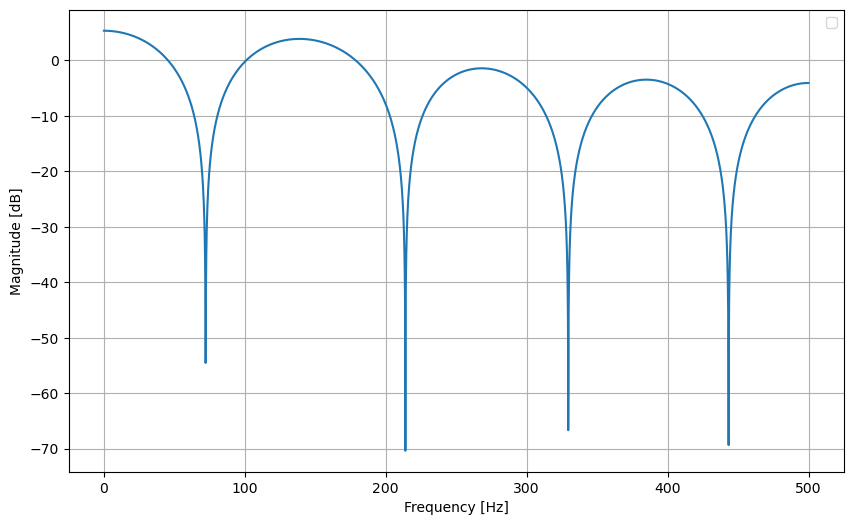

In [101]:
# Frequência de amostragem (em Hz)
fs = 1000  # Frequência de amostragem

# Calcular a resposta em frequência
w, h = freqz(2*w2, worN=8000)

# Converter radianos para Hz
frequencies_hz = w * fs / (2 * np.pi)

# Plotar a magnitude da resposta em frequência
plt.figure(figsize=(10, 6))
plt.plot(frequencies_hz, 20 * np.log10(abs(h)))
#plt.title('Resposta em Frequência do Filtro FIR')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.legend()
plt.show()

array([ 0.25657638,  0.15034387,  0.0614307 ,  0.0024492 , -0.0182385 ,
        0.00230524,  0.06118118,  0.15006041,  0.25635465])